In [ ]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

data = pd.read_csv("NIFTY_50_Historical_Data.csv")
data.set_index('Date', inplace=True)

In [3]:
cp_exog = pd.DataFrame(columns=['CP_lag1', 'CP_lag2', 'CP_lag3', 'CP_lag4', 'CP_lag5'])

In [4]:
for i in range(1, 6):
    cp_exog[f'CP_lag{i}'] = data['Close'].shift(i).fillna(method='ffill')

In [5]:
data = pd.concat([data, cp_exog], axis=1)

In [6]:
data = data.fillna(0)

In [7]:
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

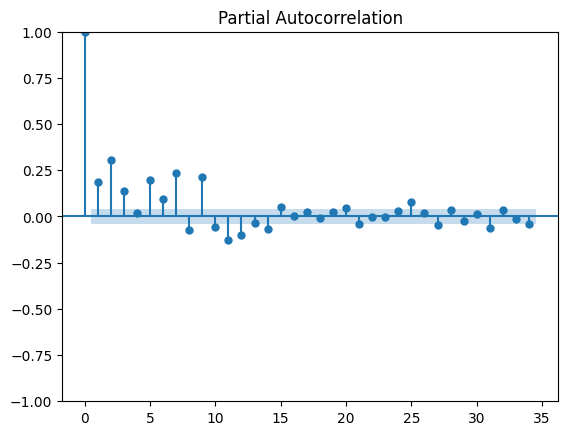

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_pacf(data['Returns']**2)
plt.show()

In [ ]:
from pmdarima import auto_arima

model = auto_arima(train['Returns'], exogenous=train[['CP_lag1', 'CP_lag2', 'CP_lag3', 'CP_lag4', 'CP_lag5']],
                   start_p=1, start_q=1,
                   test='adf',
                   max_p=4, max_q=3, m=9,
                   start_P=1, seasonal=True,
                   d=1, D=1, trend='ct',  # Adding trend component
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)


In [ ]:
model = SARIMAX(train['Returns'], exog=train[['CP_lag1', 'CP_lag2', 'CP_lag3', 'CP_lag4', 'CP_lag5']], order=(1,1,3), seasonal_order=(1, 1, 2, 9))
results = model.fit()

In [ ]:
test_pred = model.predict(n_periods=len(test),X=test[['CP_lag1', 'CP_lag2', 'CP_lag3', 'CP_lag4', 'CP_lag5']]);

In [ ]:
test_pred = results.predict(start=len(train), end=len(data)-1, exog=test[['CP_lag1', 'CP_lag2', 'CP_lag3', 'CP_lag4', 'CP_lag5']])
mse = mean_squared_error(test['Returns'], test_pred)
print(f"Mean Squared Error: {mse:.2f}")

In [17]:
df_predictions = pd.DataFrame(columns=['predictions_CP'])

In [28]:
df_predictions['predictions_CP'] = test_pred

In [30]:
df_predictions.to_csv('./output_new.csv')